<a href="https://colab.research.google.com/github/JustBNM/graph-recommend-system/blob/main/Personalized_RecSys_GNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Установка и подключение библиотек

In [2]:
import torch

def format_pytorch_version(version):
  return version.split('+')[0]

TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)

def format_cuda_version(version):
  return 'cu' + version.replace('.', '')

CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

!pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-geometric

Looking in links: https://pytorch-geometric.com/whl/torch-1.11.0+cu113.html
Looking in links: https://pytorch-geometric.com/whl/torch-1.11.0+cu113.html
Looking in links: https://pytorch-geometric.com/whl/torch-1.11.0+cu113.html
Looking in links: https://pytorch-geometric.com/whl/torch-1.11.0+cu113.html


In [3]:
!pip install umap
!pip install umap-learn

In [4]:
import os.path as osp

import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.linear_model import LogisticRegression
from torch_cluster import random_walk

import torch_geometric.transforms as T
from torch_geometric.datasets import Planetoid
from torch_geometric.loader import NeighborSampler as RawNeighborSampler
from torch_geometric.nn import SAGEConv

import umap
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter

## Пример на заготовленном датасете

In [5]:
dataset = 'Cora'
path = './data'
dataset = Planetoid(path, dataset, transform=T.NormalizeFeatures())
data = dataset[0]

Processing...
Done!


Данные:
x - 2708 статей. Каждая статья кодируется наличием слов из словаря размером 1433
edge_index - связи статей по цитиремости. 105556 связей по индексам статей

# Хреначу свой пример

## Датасет

In [5]:
from torch_geometric.data import HeteroData
import pandas as pd
import numpy as np

In [6]:
number_of_person = 500
from scipy.special import softmax
genders = np.random.randint(0, 2, number_of_person)
# пиво берут редко
pivo_buy = np.random.choice([0,1], number_of_person, p=[0.8, 0.2])
# любовь к пиву зависит от того, взяли ли его
pivo_love = np.array([pivo*np.random.normal(loc=0.6, scale=0.2, size=1) + 
                      (1 - pivo)*np.random.normal(loc=0.3, scale=0.3, size=1) for pivo in pivo_buy]).squeeze()
# картошка с пивом - хорошо
kartoshka_buy = np.array([np.random.choice([0,1], 1, p=softmax([0.5, 0.4+2*pivo])) for pivo in pivo_love])
kartoshka_love = np.array([prod_buy*np.random.normal(loc=0.6, scale=0.2, size=1) + 
                      (1 - prod_buy)*np.random.normal(loc=0.4, scale=0.3, size=1) for prod_buy in kartoshka_buy]).squeeze()
# салатик берут девушки
salatic_love = np.array([gender*np.random.normal(loc=0.2, scale=0.2, size=1) + 
                      (1 - gender)*np.random.normal(loc=0.4, scale=0.2, size=1) for gender in genders]).squeeze()
salatic_buy = np.array([np.random.choice([0,1], 1, p=softmax([0.6, 0.4+prod])) for prod in salatic_love])
# Пиво с мороженкой плохо заходит
morozenka_buy = np.array([np.random.choice([0,1], 1, p=softmax([0.6, 0.4-prod])) for prod in pivo_buy]).squeeze()
morozenka_love = 1/(0.5 + pivo_love)
cola_love = np.random.random(number_of_person)
burger_love = np.random.random(number_of_person)
# Если купил всего 1 продукт - пусть берёт колу
cola_buy = np.array([np.random.choice([0,1], 1, p=softmax([0.6, 0.4+prod])) for prod in salatic_love])
# Если кроме колы ничего не взял - пусть берёт бургер

df_user = pd.DataFrame()
df_user['gender'] = genders
df_user['pivo_love'] = pivo_love
df_user['kartoshka_love'] = kartoshka_love
df_user['salatic_love'] = salatic_love
df_user['morozenka_love'] = morozenka_love
df_user['cola_love'] = salatic_love
df_user['burger_love'] = morozenka_love


df_user['pivo_buy'] = pivo_buy
df_user['kartoshka_buy'] = kartoshka_buy
df_user['salatic_buy'] = salatic_buy
df_user['morozenka_buy'] = morozenka_buy

cola_buy = np.array(1 if sum(df_user.loc[i, ['pivo_buy', 'kartoshka_buy', 'salatic_buy', 'morozenka_buy']]) <= 1 
                                         else int(np.random.choice([0,1], 1, p=softmax([0.7, 0.3+prod]))) for i, prod in enumerate(cola_love)).squeeze()

df_user['cola_buy'] = cola_buy

burger_buy = np.array(1 if sum(df_user.loc[i, ['pivo_buy', 'kartoshka_buy', 'salatic_buy', 'morozenka_buy']]) == 0 
                                         else int(np.random.choice([0,1], 1, p=softmax([0.7, 0.3+prod]))) for i, prod in enumerate(burger_love)).squeeze()
df_user['burger_buy'] = burger_buy

In [7]:
df_user

,gender,pivo_love,kartoshka_love,salatic_love,morozenka_love,cola_love,burger_love,pivo_buy,kartoshka_buy,salatic_buy,morozenka_buy,cola_buy,burger_buy
0,0,0.007225,0.796908,0.453481,1.971513,0.453481,1.971513,0,0,0,0,1,1
1,0,0.086803,0.668206,0.181488,1.704150,0.181488,1.704150,0,1,0,0,1,1
2,0,0.247815,0.457115,0.307790,1.337229,0.307790,1.337229,0,1,0,0,1,1
3,1,-0.491794,0.369032,0.289647,121.864018,0.289647,121.864018,0,0,1,1,0,1
4,0,1.068778,0.713599,0.388044,0.637439,0.388044,0.637439,1,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,1,0.252246,0.422066,0.077148,1.329353,0.077148,1.329353,0,1,1,0,0,1
496,1,0.471849,0.605640,0.176069,1.028966,0.176069,1.028966,0,1,1,1,1,0
497,0,0.654804,0.495542,0.723017,0.865948,0.723017,0.865948,1,1,0,0,1,0
498,0,0.174672,0.348316,0.620265,1.482202,0.620265,1.482202,0,1,1,1,0,1


In [8]:
Counter(df_user.iloc[:, 7:].sum(axis=1))

Counter({2.0: 137, 3.0: 205, 4.0: 122, 5.0: 34, 6.0: 2})

In [9]:
import sklearn.preprocessing as skl
category = ['Пиво','Картошка', 'Салатик', 'Мороженка', 'cola', 'burger']
df_dish = pd.DataFrame(np.eye(6), index = category)

In [10]:
df_dish

,0,1,2,3,4,5
Пиво,1.0,0.0,0.0,0.0,0.0,0.0
Картошка,0.0,1.0,0.0,0.0,0.0,0.0
Салатик,0.0,0.0,1.0,0.0,0.0,0.0
Мороженка,0.0,0.0,0.0,1.0,0.0,0.0
cola,0.0,0.0,0.0,0.0,1.0,0.0
burger,0.0,0.0,0.0,0.0,0.0,1.0


In [11]:
df_user.iloc[:, :7].values

array([[0.        , 0.00722458, 0.7969081 , ..., 1.97151327, 0.45348117,
        1.97151327],
       [0.        , 0.0868028 , 0.66820598, ..., 1.70415002, 0.18148789,
        1.70415002],
       [0.        , 0.24781492, 0.45711529, ..., 1.33722928, 0.30779024,
        1.33722928],
       ...,
       [0.        , 0.65480363, 0.49554217, ..., 0.86594809, 0.72301704,
        0.86594809],
       [0.        , 0.1746719 , 0.348316  , ..., 1.48220195, 0.62026531,
        1.48220195],
       [1.        , 0.56144144, 0.41866355, ..., 0.94211509, 0.32127567,
        0.94211509]])

In [12]:
df_user.iloc[:, 7:] = df_user.iloc[:, 7:].astype(int) 

In [13]:
data = HeteroData()
data['user'].x = torch.from_numpy(df_user.iloc[:, 1:7].values)
data['dish'].x = torch.from_numpy(df_dish.values).float()
data['user'].y = torch.from_numpy(df_user.iloc[:, 7:].values)
#data['dish'].y = torch.from_numpy(df_dish.iloc[:, :6].values)

In [14]:
data['dish']

{'x': tensor([[1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 1.]])}

In [15]:
torch_buy_pivo = torch.stack((torch.from_numpy(df_user[df_user.pivo_buy == 1].index.values) , 
                              torch.from_numpy(np.zeros(len(df_user[df_user.pivo_buy == 1].index))) ))

In [16]:
torch_buy_kartoshka = torch.stack((torch.from_numpy(df_user[df_user.kartoshka_buy == 1].index.values) , 
                                  torch.from_numpy(np.ones(len(df_user[df_user.kartoshka_buy == 1].index))) ))
torch_buy_salatic = torch.stack((torch.from_numpy(df_user[df_user.salatic_buy == 1].index.values) , 
                                  torch.from_numpy(np.ones(len(df_user[df_user.salatic_buy == 1].index))*2) ))
torch_buy_morozenka = torch.stack((torch.from_numpy(df_user[df_user.morozenka_buy == 1].index.values) , 
                                  torch.from_numpy(np.ones(len(df_user[df_user.morozenka_buy == 1].index))*3) ))
torch_buy_cola = torch.stack((torch.from_numpy(df_user[df_user.cola_buy == 1].index.values) , 
                                  torch.from_numpy(np.ones(len(df_user[df_user.cola_buy == 1].index))*4) ))
torch_buy_burger = torch.stack((torch.from_numpy(df_user[df_user.burger_buy == 1].index.values) , 
                                  torch.from_numpy(np.ones(len(df_user[df_user.burger_buy == 1].index))*5) ))

In [17]:
data['user', 'buys', 'dish'].edge_index = torch.cat((torch_buy_pivo, torch_buy_kartoshka, torch_buy_salatic,
                                                     torch_buy_morozenka, torch_buy_cola, torch_buy_burger), axis=1)

In [18]:
data['user'].x = data['user'].x.float()

In [19]:
data['user'].x.type()

'torch.FloatTensor'

In [20]:
data['buys'].edge_index = data['buys'].edge_index.type(torch.LongTensor)

In [21]:
data = T.ToUndirected()(data)

## Гомограф

In [ ]:
data

HeteroData(
  user={
    x=[500, 6],
    y=[500, 6]
  },
  dish={ x=[6, 6] },
  (user, buys, dish)={ edge_index=[2, 1491] },
  (dish, rev_buys, user)={ edge_index=[2, 1491] }
)

In [ ]:
homogeneous_data = data.to_homogeneous()
homogeneous_data.x = homogeneous_data.x.float()

In [ ]:
data

HeteroData(
  user={
    x=[500, 6],
    y=[500, 6]
  },
  dish={
    x=[6, 6],
    y=[6, 6]
  },
  (user, buys, dish)={ edge_index=[2, 1521] },
  (dish, rev_buys, user)={ edge_index=[2, 1521] }
)

In [ ]:
homogeneous_data

Data(node_type=[506], x=[506, 6], y=[506, 6], edge_index=[2, 3042], edge_type=[3042])

In [ ]:
class NeighborSampler(RawNeighborSampler):
    def sample(self, batch):
        batch = torch.tensor(batch)
        # print(batch)
        # print(np.array(self.adj_t).shape)
        row, col, _ = self.adj_t.coo()

        # For each node in `batch`, we sample a direct neighbor (as positive
        # example) and a random node (as negative example):
        pos_batch = random_walk(row, col, batch, walk_length=1,
                                coalesced=False)[:, 1]
        # print(pos_batch)

        neg_batch = torch.randint(0, self.adj_t.size(1), (batch.numel(), ),
                                  dtype=torch.long)
        # print(neg_batch)

        batch = torch.cat([batch, pos_batch, neg_batch], dim=0)
        return super(NeighborSampler, self).sample(batch)


In [ ]:
hetero_data = data

In [ ]:
hetero_data

HeteroData(
  user={
    x=[500, 6],
    y=[500, 6]
  },
  dish={ x=[6, 6] },
  (user, buys, dish)={ edge_index=[2, 1491] },
  (dish, rev_buys, user)={ edge_index=[2, 1491] }
)

In [ ]:
#data = homogeneous_data

In [259]:
train_loader = NeighborSampler(homogeneous_data.edge_index, sizes=[1, 1], batch_size=1,
                               shuffle=True, num_nodes=data.num_nodes)

In [ ]:
from torch_geometric.loader import NeighborLoader
n_neigh = 1
loader = NeighborLoader(
    hetero_data,
    # Sample n_neigh neighbors for each node and edge type for 2 iterations
    num_neighbors={key: [n_neigh] * 2 for key in hetero_data.edge_types},
    # Use a batch size of 128 for sampling training nodes of type paper
    batch_size=1,
    input_nodes=('user'),
)

In [ ]:
hetero_data.edge_types

[('user', 'buys', 'dish'), ('dish', 'rev_buys', 'user')]

In [ ]:
iterator = iter(loader)

In [ ]:
next(iterator)

HeteroData(
  user={
    x=[2, 6],
    y=[2, 6],
    batch_size=1
  },
  dish={ x=[1, 6] },
  (user, buys, dish)={ edge_index=[2, 1] },
  (dish, rev_buys, user)={ edge_index=[2, 1] }
)

In [ ]:
class SAGE(nn.Module):
    def __init__(self, in_channels, hidden_channels, num_layers):
        super(SAGE, self).__init__()
        self.num_layers = num_layers
        self.convs = nn.ModuleList()
        
        for i in range(num_layers):
            in_channels = in_channels if i == 0 else hidden_channels
            self.convs.append(SAGEConv(in_channels, hidden_channels))

    def forward(self, x, adjs):
        for i, (edge_index, _, size) in enumerate(adjs):
            x_target = x[:size[1]]  # Target nodes are always placed first.
            #print(x, x_target)
            x = self.convs[i]((x, x_target), edge_index)
            if i != self.num_layers - 1:
                x = x.relu()
                x = F.dropout(x, p=0.5, training=self.training)
        return x

    def full_forward(self, x, edge_index):
        for i, conv in enumerate(self.convs):
            x = conv(x, edge_index)
            if i != self.num_layers - 1:
                x = x.relu()
                x = F.dropout(x, p=0.5, training=self.training)
        return x

In [216]:
data

HeteroData(
  user={
    x=[500, 6],
    y=[500, 6]
  },
  dish={ x=[6, 6] },
  (user, buys, dish)={ edge_index=[2, 1491] },
  (dish, rev_buys, user)={ edge_index=[2, 1491] }
)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SAGE(data.num_node_features, hidden_channels=64, num_layers=2)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
x, edge_index = data.x.to(device), data.edge_index.to(device)

AttributeError: ignored

In [ ]:
model.train()

total_loss = 0
for batch_size, n_id, adjs in train_loader:
    # `adjs` holds a list of `(edge_index, e_id, size)` tuples.
    adjs = [adj.to(device) for adj in adjs]
    optimizer.zero_grad()

    out = model(x[n_id], adjs)
    out, pos_out, neg_out = out.split(out.size(0) // 3, dim=0)

    pos_loss = F.logsigmoid((out * pos_out).sum(-1)).mean()
    neg_loss = F.logsigmoid(-(out * neg_out).sum(-1)).mean()
    loss = -pos_loss - neg_loss
    loss.backward()
    optimizer.step()

    total_loss += float(loss) * out.size(0)
    #break

In [ ]:
def train():
    model.train()

    total_loss = 0
    for batch_size, n_id, adjs in train_loader:
        # `adjs` holds a list of `(edge_index, e_id, size)` tuples.
        adjs = [adj.to(device) for adj in adjs]
        optimizer.zero_grad()

        out = model(x[n_id], adjs)
        out, pos_out, neg_out = out.split(out.size(0) // 3, dim=0)

        pos_loss = F.logsigmoid((out * pos_out).sum(-1)).mean()
        neg_loss = F.logsigmoid(-(out * neg_out).sum(-1)).mean()
        loss = -pos_loss - neg_loss
        loss.backward()
        optimizer.step()

        total_loss += float(loss) * out.size(0)

    return total_loss / data.num_nodes

In [ ]:
@torch.no_grad()
def test():
    model.eval()
    out = model.full_forward(x, edge_index).cpu()

    clf = LogisticRegression()
    clf.fit(out[data.train_mask], data.y[data.train_mask])

    val_acc = clf.score(out[data.val_mask], data.y[data.val_mask])
    test_acc = clf.score(out[data.test_mask], data.y[data.test_mask])

    return val_acc, test_acc

In [ ]:
for epoch in range(1, 51):
    loss = train()
    #val_acc, test_acc = test()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, ')
          #f'Val: {val_acc:.4f}, Test: {test_acc:.4f}')

Epoch: 001, Loss: 3.9374, 
Epoch: 002, Loss: 1.9053, 
Epoch: 003, Loss: 2.5082, 
Epoch: 004, Loss: 1.2902, 
Epoch: 005, Loss: 1.6550, 
Epoch: 006, Loss: 1.3754, 
Epoch: 007, Loss: 1.0893, 
Epoch: 008, Loss: 1.1739, 
Epoch: 009, Loss: 1.1811, 
Epoch: 010, Loss: 12.5970, 
Epoch: 011, Loss: 1.8660, 
Epoch: 012, Loss: 1.4447, 
Epoch: 013, Loss: 1.2702, 
Epoch: 014, Loss: 1.2241, 
Epoch: 015, Loss: 1.1750, 
Epoch: 016, Loss: 1.2588, 
Epoch: 017, Loss: 1.2314, 
Epoch: 018, Loss: 1.5580, 
Epoch: 019, Loss: 1.2436, 
Epoch: 020, Loss: 1.6134, 
Epoch: 021, Loss: 1.4148, 
Epoch: 022, Loss: 1.3466, 
Epoch: 023, Loss: 1.3291, 
Epoch: 024, Loss: 1.7191, 
Epoch: 025, Loss: 1.3414, 
Epoch: 026, Loss: 1.2195, 
Epoch: 027, Loss: 1.1805, 
Epoch: 028, Loss: 1.3871, 
Epoch: 029, Loss: 1.2027, 
Epoch: 030, Loss: 1.2019, 
Epoch: 031, Loss: 1.1076, 
Epoch: 032, Loss: 1.1174, 
Epoch: 033, Loss: 1.2475, 
Epoch: 034, Loss: 1.9446, 
Epoch: 035, Loss: 1.4923, 
Epoch: 036, Loss: 1.3843, 
Epoch: 037, Loss: 1.7037, 


In [ ]:
with torch.no_grad():
    model.eval()
    out = model.full_forward(x, edge_index).cpu()

In [ ]:
np.where(data.y[23].numpy() == 1)

(array([2, 4]),)

In [ ]:
for i in range(6):
  print(sum(data.y[:,i]))

tensor(109., dtype=torch.float64)
tensor(326., dtype=torch.float64)
tensor(260., dtype=torch.float64)
tensor(205., dtype=torch.float64)
tensor(349., dtype=torch.float64)
tensor(278., dtype=torch.float64)


In [ ]:
from numpy import linalg
for j in range(200):
  test = []
  for i in range(200, 206):
    test.append(sum(out[j].numpy() * out[i].numpy()))
  test = np.array(test)
  sorted_indices = sorted(range(len(test)), key=lambda k: test[k], reverse = True)
  # print(sorted_indices)
  # print(np.where(data.y[j].numpy() == 1))
  # print('----')

In [ ]:
# palette = {}

# for n, y in enumerate(set(data.y.numpy())):
#     palette[y] = f'C{n}'

palette = {}

for n, y in enumerate(set(data.y[:,1].numpy())):
    palette[y] = f'C{n}'

In [ ]:
embd = umap.UMAP().fit_transform(out.cpu().numpy())

In [ ]:
sum(data.y[:,0].cpu().numpy() * data.y[:,1].cpu().numpy() * data.y[:,2].cpu().numpy())

46.0

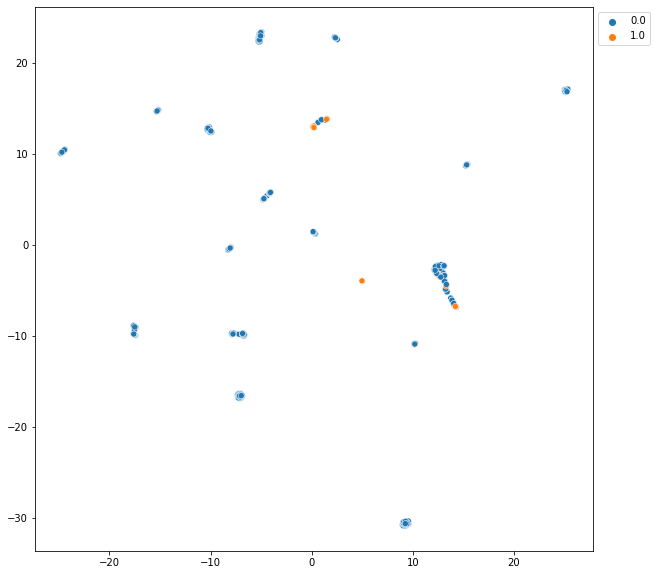

In [ ]:
plt.figure(figsize=(10, 10))
sns.scatterplot(x=embd.T[0], y=embd.T[1], hue=data.y[:,0].cpu().numpy() * data.y[:,1].cpu().numpy() * data.y[:,2].cpu().numpy(), palette=palette)
plt.legend(bbox_to_anchor=(1,1), loc='upper left')
#plt.savefig("umap_embd_sage.png", dpi=120)

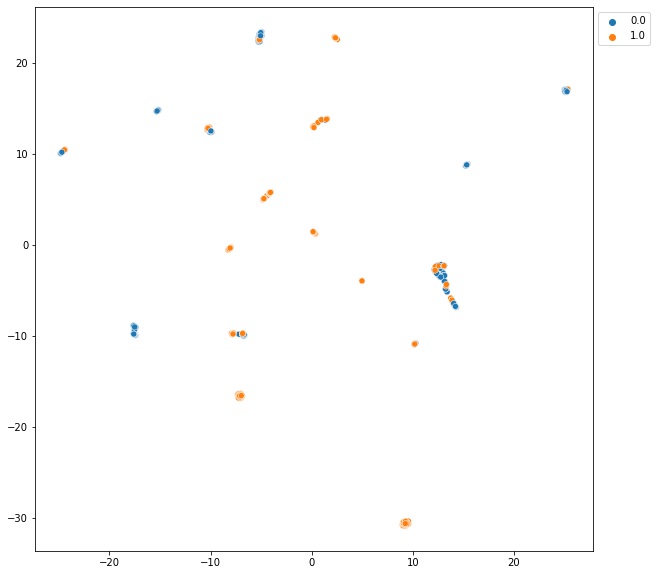

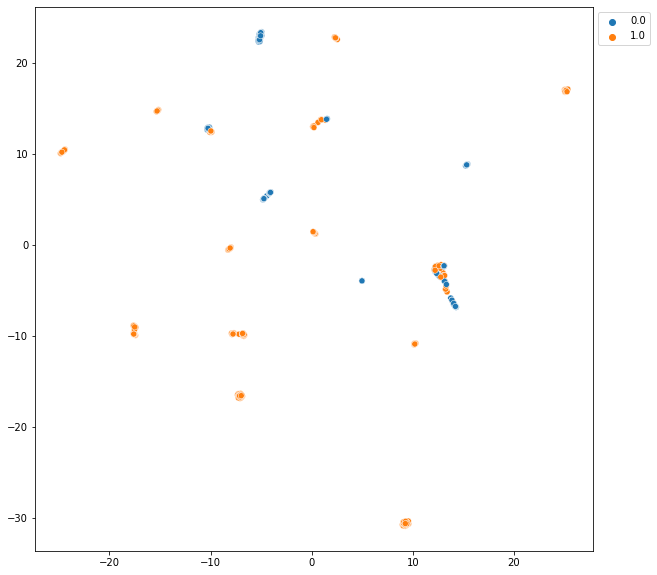

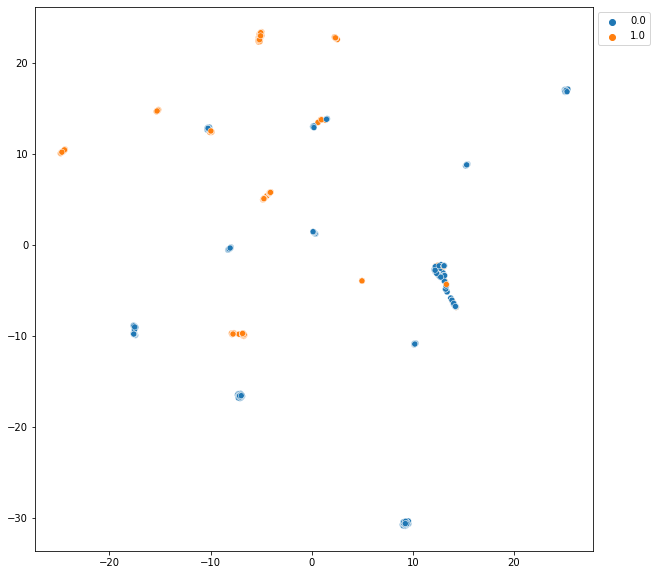

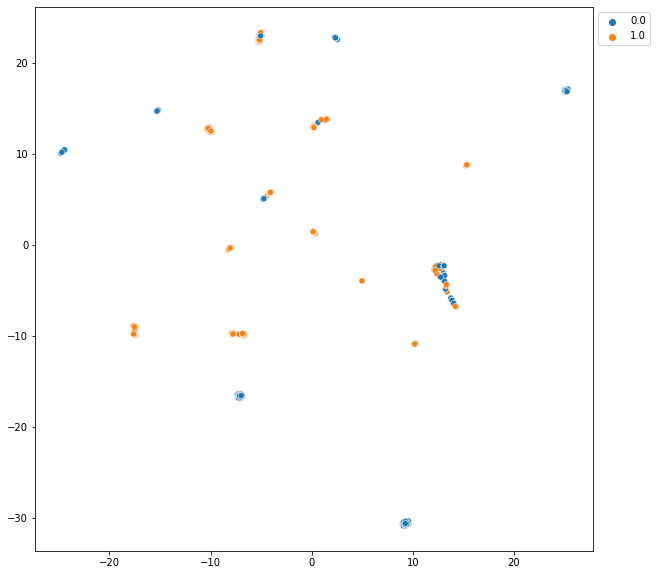

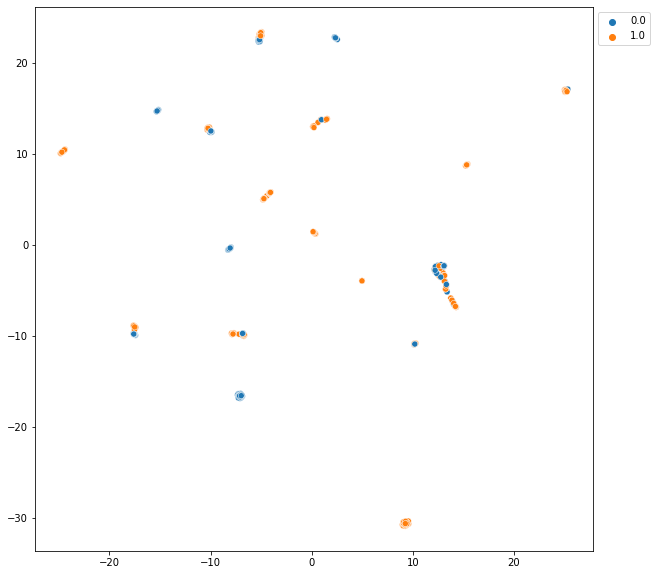

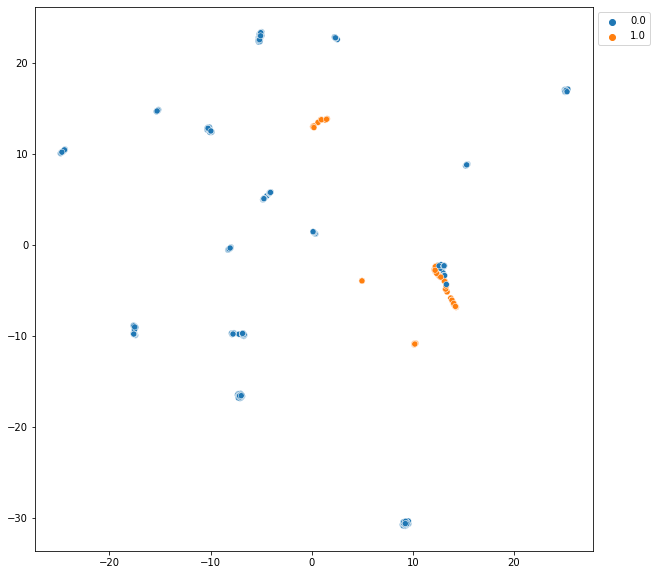

In [ ]:
for i in range(5,-1, -1):
  plt.figure(figsize=(10, 10))
  sns.scatterplot(x=embd.T[0], y=embd.T[1], hue=data.y[:,i].cpu().numpy(), palette=palette)
  plt.legend(bbox_to_anchor=(1,1), loc='upper left')
  #plt.savefig("umap_embd_sage.png", dpi=120)

In [ ]:
embd_x = umap.UMAP().fit_transform(data.x.numpy())

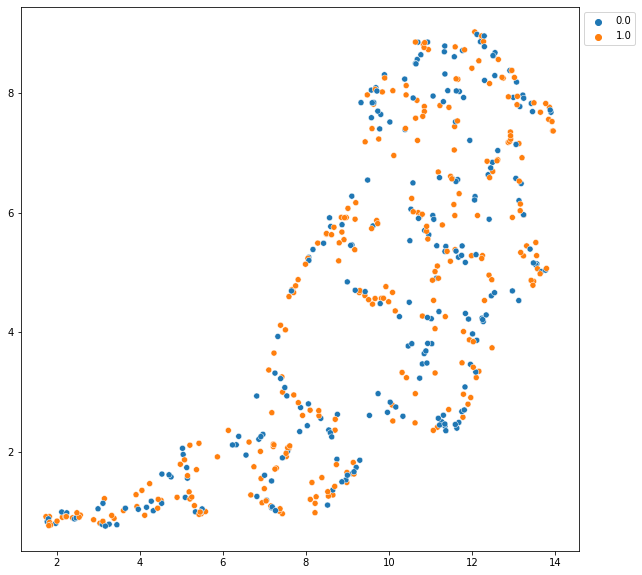

In [ ]:
plt.figure(figsize=(10, 10))
sns.scatterplot(x=embd_x.T[0], y=embd_x.T[1], hue=data.y[:,5].cpu().numpy(), palette=palette)
plt.legend(bbox_to_anchor=(1,1), loc='upper left')
plt.savefig("umap_embd.png", dpi=120)

## Гетерограф

In [22]:
hetero_data = data

In [22]:
data['dish']

{'x': tensor([[1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 1.]])}

In [23]:
from torch_geometric.loader import NeighborLoader
n_neigh = 1
loader = NeighborLoader(
    hetero_data,
    # Sample n_neigh neighbors for each node and edge type for 2 iterations
    num_neighbors={key: [n_neigh] * 2 for key in hetero_data.edge_types},
    # Use a batch size of 128 for sampling training nodes of type paper
    batch_size=1,
    input_nodes=('user'),
)

In [27]:
class SAGE(nn.Module):
    def __init__(self, in_channels, hidden_channels, num_layers):
        super(SAGE, self).__init__()
        self.num_layers = num_layers
        self.convs = nn.ModuleList()
        
        for i in range(num_layers):
            in_channels = in_channels if i == 0 else hidden_channels
            self.convs.append(SAGEConv(in_channels, hidden_channels))

    def forward(self, x, adjs):
        for i, (edge_index, _, size) in enumerate(adjs):
            x_target = x[:size[1]]  # Target nodes are always placed first.
            #print(x, x_target)
            x = self.convs[i]((x, x_target), edge_index)
            if i != self.num_layers - 1:
                x = x.relu()
                x = F.dropout(x, p=0.5, training=self.training)
        return x

    def full_forward(self, x, edge_index):
        for i, conv in enumerate(self.convs):
            x = conv(x, edge_index)
            if i != self.num_layers - 1:
                x = x.relu()
                x = F.dropout(x, p=0.5, training=self.training)
        return x

In [28]:
from torch_geometric.nn import SAGEConv, to_hetero

In [29]:
import torch_geometric.transforms as T
from torch_geometric.datasets import OGB_MAG
from torch_geometric.nn import SAGEConv, to_hetero


# dataset = OGB_MAG(root='./data', preprocess='metapath2vec', transform=T.ToUndirected())
# data = dataset[0]

class GNN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.conv1 = SAGEConv((-1, -1), hidden_channels)
        self.conv2 = SAGEConv((-1, -1), hidden_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x


model = GNN(hidden_channels=64)
model = to_hetero(model, data.metadata(), aggr='sum')

In [33]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = SAGE(data['user'].num_node_features, hidden_channels=64, num_layers=2)
# model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
#x, edge_index = data.x.to(device), data.edge_index.to(device)

### Эксперименты с SparceTensor

In [34]:
from torch_sparse import SparseTensor
edge_index = a[2][0].edge_index
is_sparse_tensor = isinstance(edge_index, SparseTensor)
is_sparse_tensor

NameError: ignored

In [345]:
edge_index

tensor([[3, 4, 5, 6, 7, 8],
        [0, 1, 2, 3, 4, 5]])

In [354]:
SparseTensor(row=torch.tensor([0, 10, 2, 3, 4, 5]), col=torch.tensor([3, 4, 5, 6, 7, 8]))

SparseTensor(row=tensor([ 0,  2,  3,  4,  5, 10]),
             col=tensor([3, 5, 6, 7, 8, 4]),
             size=(11, 9), nnz=6, density=6.06%)

In [290]:
homogeneous_data.edge_index.numpy()[0]

array([  0,   4,   6, ..., 505, 505, 505])

In [275]:
edge_index[0], edge_index[1]

(tensor([3, 4, 5, 6, 7, 8]), tensor([0, 1, 2, 3, 4, 5]))

In [ ]:
pos_batch = random_walk(homogeneous_data.edge_index.numpy()[0], homogeneous_data.edge_index.numpy()[1], batch, walk_length=1,
                                coalesced=False)[:, 1]

In [335]:
random_walk(torch.LongTensor(homogeneous_data.edge_index.numpy()[0]), torch.LongTensor(homogeneous_data.edge_index.numpy()[1]),
            start = torch.LongTensor([353]), walk_length=1, coalesced=False)#[:, 1]

tensor([[353, 504]])

In [261]:
for a in loader:
  print(a)
  break

HeteroData(
  user={
    x=[2, 6],
    y=[2, 6],
    batch_size=1
  },
  dish={ x=[1, 6] },
  (user, buys, dish)={ edge_index=[2, 1] },
  (dish, rev_buys, user)={ edge_index=[2, 1] }
)


### Конец экспериментов

In [35]:
def train():
    model.train()

    total_examples = total_loss = 0
    for batch in loader:
            optimizer.zero_grad()
            #batch = batch.to('cuda:0')
            batch_size = batch['user'].batch_size
            #print(batch['user'].y)

            out = model(batch.x_dict,
                        batch.edge_index_dict)
            #break

            ### negative sampling
            neg_dish = []
            for element in batch['user'].y[:batch_size]:
              list_ = np.where(element == 0)[0]
              if list_ != []:
                neg_dish.append(np.random.choice(list_))
              else: 
                neg_dish.append(np.random.choice(np.arange(len(element))))
      
            n_neigh = 4
            dish_loader = NeighborLoader(
                hetero_data,
                # Sample n_neigh neighbors for each node and edge type for 2 iterations
                num_neighbors={key: [n_neigh] * 5 for key in hetero_data.edge_types},
                # Use a batch size of 128 for sampling training nodes of type paper
                batch_size=1,
                input_nodes=('dish', torch.Tensor(neg_dish)),
            )
            for dish_batch in dish_loader:
              optimizer.zero_grad()
              #batch = batch.to('cuda:0')
              batch_size = dish_batch['dish'].batch_size

              neg_out = model(dish_batch.x_dict,
                            dish_batch.edge_index_dict)


            # loss = F.cross_entropy(out['paper'][:batch_size],
            #                        batch['paper'].y[:batch_size])
            #print(out['user'][:batch_size])
            pos_loss = F.logsigmoid((out['user'][:batch_size] * out['dish'][:batch_size]).sum(-1)).mean()
            neg_loss = F.logsigmoid(-(out['user'][:batch_size] * neg_out['dish'][:batch_size]).sum(-1)).mean()
            loss = -pos_loss - neg_loss
            loss.backward()
            optimizer.step()

            total_examples += batch_size
            total_loss += float(loss) * batch_size
    return total_loss / total_examples

In [36]:
for _ in range(30):
  loss = train()
  print(loss)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


0.06568383193403463
0.04518243379048968
0.049617464832515494
0.03218825472958178
0.0623771995047057
0.029383068779698363
0.01752517777259186
0.05609540079538625
0.019650252140938754
0.018125827385789606
0.03764702872410146
0.05514342175259945
0.021027875843694345
0.04394341115635632
0.05909128045429975
0.02950799059372777
0.024704909974287138
0.027832486398416848
0.014042721534665873
0.03282014444688957
0.010638899723816455
0.03141306003818431
0.43076221672342757
0.05711444056839957
0.010905103214215667
0.03920927430155932
0.01939803134925314
0.016235958771174046
0.007093063900922129
0.02966005045744569


In [ ]:
@torch.no_grad()
def test():
    model.eval()
    out = model.full_forward(x, edge_index).cpu()

    clf = LogisticRegression()
    clf.fit(out[data.train_mask], data.y[data.train_mask])

    val_acc = clf.score(out[data.val_mask], data.y[data.val_mask])
    test_acc = clf.score(out[data.test_mask], data.y[data.test_mask])

    return val_acc, test_acc

In [ ]:
for epoch in range(1, 51):
    loss = train()
    #val_acc, test_acc = test()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, ')
          #f'Val: {val_acc:.4f}, Test: {test_acc:.4f}')

Epoch: 001, Loss: 3.9374, 
Epoch: 002, Loss: 1.9053, 
Epoch: 003, Loss: 2.5082, 
Epoch: 004, Loss: 1.2902, 
Epoch: 005, Loss: 1.6550, 
Epoch: 006, Loss: 1.3754, 
Epoch: 007, Loss: 1.0893, 
Epoch: 008, Loss: 1.1739, 
Epoch: 009, Loss: 1.1811, 
Epoch: 010, Loss: 12.5970, 
Epoch: 011, Loss: 1.8660, 
Epoch: 012, Loss: 1.4447, 
Epoch: 013, Loss: 1.2702, 
Epoch: 014, Loss: 1.2241, 
Epoch: 015, Loss: 1.1750, 
Epoch: 016, Loss: 1.2588, 
Epoch: 017, Loss: 1.2314, 
Epoch: 018, Loss: 1.5580, 
Epoch: 019, Loss: 1.2436, 
Epoch: 020, Loss: 1.6134, 
Epoch: 021, Loss: 1.4148, 
Epoch: 022, Loss: 1.3466, 
Epoch: 023, Loss: 1.3291, 
Epoch: 024, Loss: 1.7191, 
Epoch: 025, Loss: 1.3414, 
Epoch: 026, Loss: 1.2195, 
Epoch: 027, Loss: 1.1805, 
Epoch: 028, Loss: 1.3871, 
Epoch: 029, Loss: 1.2027, 
Epoch: 030, Loss: 1.2019, 
Epoch: 031, Loss: 1.1076, 
Epoch: 032, Loss: 1.1174, 
Epoch: 033, Loss: 1.2475, 
Epoch: 034, Loss: 1.9446, 
Epoch: 035, Loss: 1.4923, 
Epoch: 036, Loss: 1.3843, 
Epoch: 037, Loss: 1.7037, 


In [ ]:
with torch.no_grad():
    model.eval()
    out = model.full_forward(x, edge_index).cpu()

In [38]:
full_out = []
with torch.no_grad():
      model.eval()
      for batch in loader:
            #batch = batch.to('cuda:0')
            batch_size = batch['user'].batch_size
            #print(batch['user'].y)

            out = model(batch.x_dict,
                        batch.edge_index_dict)
            full_out.extend(out['user'][:batch_size].cpu().numpy())

In [39]:
for i in range(6):
  print(sum(data['user'].y[:,i]))

tensor(98)
tensor(325)
tensor(270)
tensor(209)
tensor(361)
tensor(296)


In [ ]:
from numpy import linalg
for j in range(200):
  test = []
  for i in range(200, 206):
    test.append(sum(out[j].numpy() * out[i].numpy()))
  test = np.array(test)
  sorted_indices = sorted(range(len(test)), key=lambda k: test[k], reverse = True)
  # print(sorted_indices)
  # print(np.where(data.y[j].numpy() == 1))
  # print('----')

In [40]:
# palette = {}

# for n, y in enumerate(set(data.y.numpy())):
#     palette[y] = f'C{n}'

palette = {}

for n, y in enumerate(set(data['user'].y[:,1].numpy())):
    palette[y] = f'C{n}'

In [41]:
#embd = umap.UMAP().fit_transform(out.cpu().numpy())
embd = umap.UMAP().fit_transform(np.array(full_out))

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


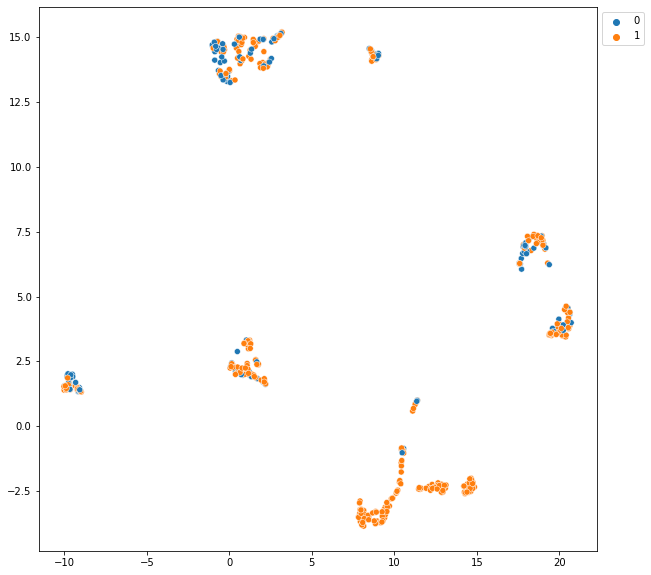

In [55]:
plt.figure(figsize=(10, 10))
sns.scatterplot(x=embd.T[0], y=embd.T[1], hue=data['user'].y[:,4].cpu().numpy(), palette=palette)
plt.legend(bbox_to_anchor=(1,1), loc='upper left')
#plt.savefig("umap_embd_sage.png", dpi=120)

In [43]:
embd_x = umap.UMAP().fit_transform(data['user'].x.numpy())

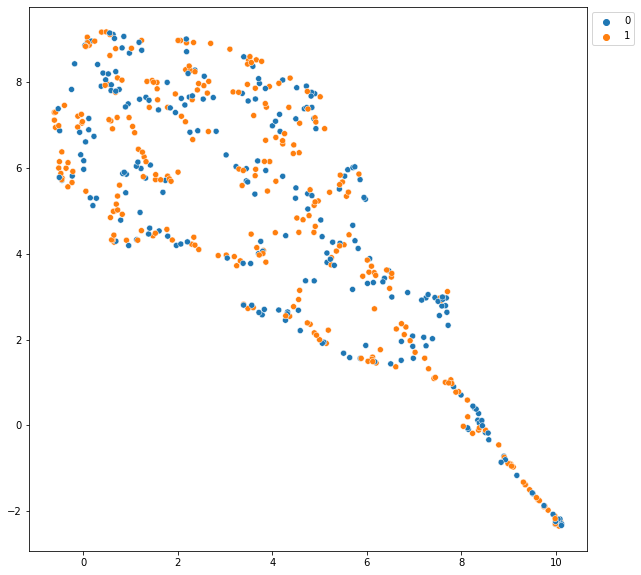

In [51]:
plt.figure(figsize=(10, 10))
sns.scatterplot(x=embd_x.T[0], y=embd_x.T[1], hue=data['user'].y[:,2].cpu().numpy(), palette=palette)
plt.legend(bbox_to_anchor=(1,1), loc='upper left')
plt.savefig("umap_embd.png", dpi=120)

### Работа с визуализацией

In [ ]:
homogeneous_data = data.to_homogeneous()
print(homogeneous_data)

import torch_geometric
import networkx as nx

g = torch_geometric.utils.to_networkx(homogeneous_data, to_undirected=True)

Data(node_type=[206], x=[206, 7], edge_index=[2, 1240], edge_type=[1240])


In [ ]:
homogeneous_data.node_type

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
        1, 1])

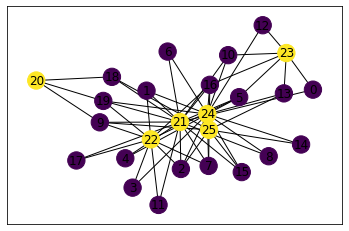

In [ ]:
nx.draw_networkx(g, node_color = homogeneous_data.node_type,)

In [ ]:
!pip install pygraphviz

  Using cached pygraphviz-1.7.zip (118 kB)
  Created wheel for pygraphviz: filename=pygraphviz-1.7-cp37-cp37m-linux_x86_64.whl size=165743 sha256=026599c27849b406bde8a4b6b463764d95114075cd66854595cfc0c8375282f2
  Stored in directory: /root/.cache/pip/wheels/8c/bc/0c/ac35392b72556e75107ff610cb31b313e8471918a6d280e34c
Successfully built pygraphviz


In [ ]:
!pip install dgl
import dgl

     |████████████████████████████████| 4.4 MB 7.8 MB/s 
Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


DGL backend not selected or invalid.  Assuming PyTorch for now.
Using backend: pytorch


In [ ]:
G = dgl.heterograph({
        ('user', 'buys', 'dish') : (np.array(data['buys'].edge_index[0]),np.array(data['buys'].edge_index[1]))
    })

print(G)

Graph(num_nodes={'dish': 3, 'user': 3},
      num_edges={('user', 'buys', 'dish'): 4},
      metagraph=[('user', 'dish', 'buys')])


In [ ]:
G

Graph(num_nodes={'dish': 3, 'user': 3},
      num_edges={('user', 'buys', 'dish'): 4},
      metagraph=[('user', 'dish', 'buys')])

In [ ]:
# Draw the metagraph using graphviz.
import pygraphviz as pgv

def plot_graph(nxg):
    ag = pgv.AGraph(strict=False, directed=True)
    for u, v, k in nxg.edges(keys=True):
        ag.add_edge(u, v, label=k)
    ag.layout('dot')
    ag.draw('graph.png')

plot_graph(G.metagraph())

AttributeError: ignored

### Конец визуализации

In [ ]:
class SAGE(nn.Module):
    def __init__(self, hidden_channels, num_layers):
        super(SAGE, self).__init__()
        self.num_layers = num_layers
        self.convs = nn.ModuleList()
        
        for i in range(num_layers):
            if i == 0:
              self.convs.append(SAGEConv((-1, -1), hidden_channels))
            else:
              self.convs.append(SAGEConv(hidden_channels, hidden_channels))

    def forward(self, x, adjs):
        for i, (edge_index, _, size) in enumerate(adjs):
            x_target = x[:size[1]]  # Target nodes are always placed first.
            x = self.convs[i]((x, x_target), edge_index)
            if i != self.num_layers - 1:
                x = x.relu()
                x = F.dropout(x, p=0.5, training=self.training)
        return x

    def full_forward(self, x, edge_index):
        for i, conv in enumerate(self.convs):
            x = conv(x, edge_index)
            if i != self.num_layers - 1:
                x = x.relu()
                x = F.dropout(x, p=0.5, training=self.training)
        return x

In [ ]:
class SAGE(nn.Module):
    def __init__(self, in_channels, hidden_channels, num_layers):
        super(SAGE, self).__init__()
        self.num_layers = num_layers
        self.convs = nn.ModuleList()
        
        for i in range(num_layers):
            in_channels = in_channels if i == 0 else hidden_channels
            self.convs.append(SAGEConv(in_channels, hidden_channels))

    def forward(self, x, adjs):
        for i, (edge_index, _, size) in enumerate(adjs):
            x_target = x[:size[1]]  # Target nodes are always placed first.
            #print(x, x_target)
            x = self.convs[i]((x, x_target), edge_index)
            if i != self.num_layers - 1:
                x = x.relu()
                x = F.dropout(x, p=0.5, training=self.training)
        return x

    def full_forward(self, x, edge_index):
        for i, conv in enumerate(self.convs):
            x = conv(x, edge_index)
            if i != self.num_layers - 1:
                x = x.relu()
                x = F.dropout(x, p=0.5, training=self.training)
        return x

In [34]:
import torch_geometric.transforms as T
from torch_geometric.datasets import OGB_MAG
from torch_geometric.nn import SAGEConv, to_hetero


# dataset = OGB_MAG(root='./data', preprocess='metapath2vec', transform=T.ToUndirected())
# data = dataset[0]

class GNN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.conv1 = SAGEConv((-1, -1), hidden_channels)
        self.conv2 = SAGEConv((-1, -1), hidden_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x


model = GNN(hidden_channels=64)
model = to_hetero(model, data.metadata(), aggr='sum')

In [35]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
#x, edge_index = data['user'].x.to(device), data['buys'].edge_index.to(device)

In [ ]:
def train():
    model.train()

    total_loss = 0
    for batch_size, n_id, adjs in train_loader:
        # `adjs` holds a list of `(edge_index, e_id, size)` tuples.
        adjs = [adj.to(device) for adj in adjs]
        optimizer.zero_grad()

        out = model(x[n_id], adjs)
        out, pos_out, neg_out = out.split(out.size(0) // 3, dim=0)

        pos_loss = F.logsigmoid((out * pos_out).sum(-1)).mean()
        neg_loss = F.logsigmoid(-(out * neg_out).sum(-1)).mean()
        loss = -pos_loss - neg_loss
        loss.backward()
        optimizer.step()

        total_loss += float(loss) * out.size(0)

    return total_loss / data.num_nodes

In [ ]:
loss = train()

IndexError: ignored

### https://pytorch-geometric.readthedocs.io/en/latest/notes/heterogeneous.html

In [29]:
import torch_geometric.transforms as T
from torch_geometric.datasets import OGB_MAG
from torch_geometric.nn import SAGEConv, to_hetero


dataset = OGB_MAG(root='./data', preprocess='metapath2vec', transform=T.ToUndirected())
data = dataset[0]

class GNN(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = SAGEConv((-1, -1), hidden_channels)
        self.conv2 = SAGEConv((-1, -1), out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x


model = GNN(hidden_channels=64, out_channels=dataset.num_classes)
model = to_hetero(model, data.metadata(), aggr='sum')

In [28]:
model.to(device)

NameError: ignored

In [30]:
import torch_geometric.transforms as T
from torch_geometric.datasets import OGB_MAG
from torch_geometric.loader import NeighborLoader

transform = T.ToUndirected()  # Add reverse edge types.
data = OGB_MAG(root='./data', preprocess='metapath2vec', transform=transform)[0]

train_loader = NeighborLoader(
    data,
    # Sample 15 neighbors for each node and each edge type for 2 iterations:
    num_neighbors=[5] * 2,
    # Use a batch size of 128 for sampling training nodes of type "paper":
    batch_size=128,
    input_nodes=('paper', data['paper'].train_mask),
)

batch_ = next(iter(train_loader))

In [7]:
def train():
    model.train()

    total_examples = total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        batch = batch.to('cuda:0')
        batch_size = batch['paper'].batch_size
        out = model(batch.x_dict, batch.edge_index_dict)
        loss = F.cross_entropy(out['paper'][:batch_size],
                               batch['paper'].y[:batch_size])
        loss.backward()
        optimizer.step()

        total_examples += batch_size
        total_loss += float(loss) * batch_size

    return total_loss / total_examples

In [15]:
for _ in range(5):
  loss = train()
  print(loss)

2.460340871522056
2.421613215654865
2.418862276977774
2.4105351814238567
2.408808349571423


### Link prediction with dgl

In [1]:
import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F
import itertools
import numpy as np
import scipy.sparse as sp

ModuleNotFoundError: ignored

### [Link Prediction Recommendation Engines with Node2Vec](https://towardsdatascience.com/link-prediction-recommendation-engines-with-node2vec-c97c429351a8)

In [4]:
!pip3 install arxiv
!pip3 install node2vec

  Created wheel for node2vec: filename=node2vec-0.4.3-py3-none-any.whl size=5980 sha256=02a5d0d199dd25dfadd897f93f247ccee8d797c4d5ab6f3119e279b411fd4c36
  Stored in directory: /root/.cache/pip/wheels/07/62/78/5202cb8c03cbf1593b48a8a442fca8ceec2a8c80e22318bae9
Successfully built node2vec


In [5]:
import networkx as nx
import pandas as pd
import numpy as np
import arxiv

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, matthews_corrcoef, confusion_matrix, classification_report
from itertools import product
from sklearn.metrics.pairwise import cosine_similarity
from node2vec import Node2Vec as n2v

# constants
queries = [
    'automl', 'machinelearning', 'data', 'phyiscs','mathematics', 'recommendation system', 'nlp', 'neural networks'
]

def search_arxiv(queries, max_results = 100):
    '''
    This function will search arxiv associated to a set of queries and store
    the latest 10000 (max_results) associated to that search.
    
    params:
        queries (List -> Str) : A list of strings containing keywords you want
                                to search on Arxiv
        max_results (Int) : The maximum number of results you want to see associated
                            to your search. Default value is 1000, capped at 300000
                            
    returns:
        This function will return a DataFrame holding the following columns associated
        to the queries the user has passed. 
            `title`, `date`, `article_id`, `url`, `main_topic`, `all_topics`
    
    example:
        research_df = search_arxiv(
            queries = ['automl', 'recommender system', 'nlp', 'data science'],
            max_results = 10000
        )
    '''
    d = []
    searches = []
    # hitting the API
    for query in queries:
        search = arxiv.Search(
          query = query,
          max_results = max_results,
          sort_by = arxiv.SortCriterion.SubmittedDate,
          sort_order = arxiv.SortOrder.Descending
        )
        searches.append(search)
    
    # Converting search result into df
    for search in searches:
        for res in search.results():
            data = {
                'title' : res.title,
                'date' : res.published,
                'article_id' : res.entry_id,
                'url' : res.pdf_url,
                'main_topic' : res.primary_category,
                'all_topics' : res.categories,
                'authors' : res.authors
            }
            d.append(data)
        
    d = pd.DataFrame(d)
    d['year'] = pd.DatetimeIndex(d['date']).year
    
    # change article id from url to integer
    unique_article_ids = d.article_id.unique()
    article_mapping = {art:idx for idx,art in enumerate(unique_article_ids)}
    d['article_id'] = d['article_id'].map(article_mapping)
    return d
  
research_df = search_arxiv(
    queries = queries,
    max_results = 100
)
print(research_df.shape)

(646, 8)
